In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import colorsys
import pywt
import random
import os

SAMPLING_RATE = 100 # Hz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}")
# print(f"Device name: {torch.cuda.get_device_name(0)}")


def plot_in_time(tensor_input, sampling_rate=100, x_min=-1, y_min=-1, x_max=1, y_max=1, labels=None, plot_size=(700, 500)):
    """
    Plot 1D or 2D PyTorch tensors representing valence-arousal data in an interactive 3D plot using Plotly.
    Each tensor's data is represented by a unique color, with time evolution shown by color opacity.
    
    Args:
    tensor_input (torch.Tensor or list): A single PyTorch tensor or a list of tensors.
                                         Each tensor can be 1D (assumed to be valence) or 2D (valence-arousal).
    sampling_rate (int): The sampling rate of the data in Hz. Default is 100 Hz.
    x_min, y_min, x_max, y_max: The range for x and y axes.
    labels (list): Optional list of labels for each tensor. If None, default labels will be used.
    plot_size (tuple): Size of the plot in pixels (width, height). Default is (700, 500).
    
    Returns:
    None (displays the interactive plot in the default web browser)
    """
    fig = go.Figure()

    # Ensure tensor_input is a list
    if isinstance(tensor_input, torch.Tensor):
        tensor_input = [tensor_input]

    num_tensors = len(tensor_input)
    colors = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b in 
              [colorsys.hsv_to_rgb(h, 0.8, 0.8) for h in np.linspace(0, 1, num_tensors, endpoint=False)]]

    time_step = 1 / sampling_rate

    for i, tensor in enumerate(tensor_input):
        data = tensor.cpu().numpy()
        
        # Handle 1D and 2D tensors
        if data.ndim == 1:
            valence = data
            arousal = np.zeros_like(valence)  # Dummy arousal
        elif data.ndim == 2:
            valence = data[:, 0]
            arousal = data[:, 1]
        else:
            raise ValueError(f"Tensor {i} has unsupported dimensionality: {data.ndim}")
        
        time = np.arange(len(valence)) * time_step

        base_color = np.array([int(c) for c in colors[i].strip('rgb(').strip(')').split(',')])
        color_array = [f'rgba({base_color[0]},{base_color[1]},{base_color[2]},{0.3 + 0.7 * (t / time[-1])})' for t in time]

        scatter_trace = go.Scatter3d(
            x=valence, y=arousal, z=time,
            mode='lines+markers',
            line=dict(color=colors[i], width=3),
            marker=dict(
                size=2,
                color=color_array,
                opacity=0.8
            ),
            name=labels[i] if labels and i < len(labels) else f'Tensor {i+1}'
        )
        
        fig.add_trace(scatter_trace)

    # Add a slider for time axis scaling
    sliders = [
        dict(
            active=1,
            currentvalue={"prefix": "Time Scale: "},
            pad={"t": 50},
            steps=[
                dict(label="0.5x", method="relayout", args=[{"scene.aspectratio.z": 0.5}]),
                dict(label="1x", method="relayout", args=[{"scene.aspectratio.z": 1}]),
                dict(label="2x", method="relayout", args=[{"scene.aspectratio.z": 2}]),
                dict(label="3x", method="relayout", args=[{"scene.aspectratio.z": 3}]),
            ]
        )
    ]

    fig.update_layout(
        scene=dict(
            xaxis_title='X (Valence)',
            yaxis_title='Y (Arousal)',
            zaxis_title='Time (s)',
            xaxis=dict(range=[x_min, x_max]),
            yaxis=dict(range=[y_min, y_max]),
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=1)
        ),
        title='Interactive 3D Visualization of Valence-Arousal Data Over Time',
        legend_title_text='Data Series',
        legend=dict(
            itemsizing='constant',
            font=dict(size=10),
            borderwidth=2
        ),
        width=plot_size[0],
        height=plot_size[1],
        sliders=sliders
    )

    fig.show()

def plot_matrix(hidden_state_sequence, num_features_to_plot=None, figsize=(9, 5), title="Plotted Matrix"):
    """
    Plot the evolution of hidden state features over time.
    
    Args:
        hidden_state_sequence (torch.Tensor or np.ndarray): Hidden state sequence of shape (num_time_steps, num_features)
        num_features_to_plot (int, optional): Number of features to plot. If None, all features are plotted.
        figsize (tuple, optional): Figure size (width, height) in inches. Default is (12, 8).
    """
    if isinstance(hidden_state_sequence, torch.Tensor):
        hidden_state_sequence = hidden_state_sequence.cpu().detach().numpy()
    
    num_time_steps, num_features = hidden_state_sequence.shape
    
    if num_features_to_plot is None or num_features_to_plot > num_features:
        num_features_to_plot = num_features
    
    colors = plt.cm.rainbow(np.linspace(0, 1, num_features_to_plot))
    
    plt.figure(figsize=figsize)
    for i in range(num_features_to_plot):
        plt.plot(range(num_time_steps), hidden_state_sequence[:, i], color=colors[i], label=f'Feature {i+1}')
    
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


def load_DSI_eeg_data(file_path):
    """
    Load EEG data from a file and convert it to two separate PyTorch tensors:
    one for EEG data and one for labels (valence and arousal).
    
    Args:
    file_path (str): Path to the data file.
    
    Returns:
    tuple: (eeg_data, labels)
        eeg_data (torch.Tensor): A timesteps x 6 tensor containing the EEG data for 6 channels.
        labels (torch.Tensor): A timesteps x 2 tensor where the first column is valence
                               and the second column is arousal.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        labels = []
        eeg_data = []
        
        for line in lines:
            parts = line.strip().split(',')
            valence, arousal = map(float, parts[1:3])
            
            eeg_values = [float(channel.split('=')[1]) for channel in parts[3].split() if not channel.startswith('TRG=')]
            
            labels.append([valence, arousal])
            eeg_data.append(eeg_values)
        
        labels = torch.tensor(labels, dtype=torch.float32)
        eeg_data = torch.tensor(eeg_data, dtype=torch.float32)
        
        eeg_data = eeg_data.to(device)
        labels = labels.to(device)
        
        return eeg_data, labels
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except ValueError as e:
        print(f"Error: Invalid data format - {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return None, None

def load_multiple_DSI_eeg_files(folder_path):
    """
    Load EEG data from all files in a given folder using the load_bitalino_eeg_data function.
    
    Args:
    folder_path (str): Path to the folder containing the data files.
    
    Returns:
    tuple: (datas_array, labels_array)
        datas_array (list): A list of torch.Tensor, each of shape (timesteps, 6) containing the EEG data.
        labels_array (list): A list of torch.Tensor, each of shape (timesteps, 2) where the first column is valence
                             and the second column is arousal.
    """
    datas_array = []
    labels_array = []
    
    try:
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):  # Assuming all data files have .txt extension
                file_path = os.path.join(folder_path, filename)
                
                eeg_data, labels = load_DSI_eeg_data(file_path)
                
                if eeg_data is not None and labels is not None:
                    datas_array.append(eeg_data)
                    labels_array.append(labels)
                else:
                    print(f"Warning: Failed to load data from {filename}")
        
        if not datas_array:
            print(f"No valid data files found in {folder_path}")
        else:
            print(f"Successfully loaded {len(datas_array)} data files from {folder_path}")
        
        return datas_array, labels_array
    
    except FileNotFoundError:
        print(f"Error: Folder not found at {folder_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return [], []

def train_test_split(data_array, labels_array, test_size=0.05, shuffle=True, random_seed=None):
    """
    Split the data and labels into training and validation sets, ensuring each set has at least one element.
    
    Args:
    data_array (list): List of torch.Tensor containing the EEG data.
    labels_array (list): List of torch.Tensor containing the labels.
    test_size (float): Proportion of the dataset to include in the validation split (0.0 to 1.0).
    shuffle (bool): Whether to shuffle the data before splitting.
    random_seed (int): Seed for random number generator to ensure reproducibility.
    
    Returns:
    tuple: (train_data, train_labels, val_data, val_labels)
        train_data (list): List of torch.Tensor containing the training EEG data.
        train_labels (list): List of torch.Tensor containing the training labels.
        val_data (list): List of torch.Tensor containing the validation EEG data.
        val_labels (list): List of torch.Tensor containing the validation labels.
    """
    if len(data_array) != len(labels_array):
        raise ValueError("data_array and labels_array must have the same length")
    
    if len(data_array) < 2:
        raise ValueError("data_array must contain at least 2 elements to perform a split")
    
    if test_size <= 0 or test_size >= 1:
        raise ValueError("test_size must be between 0 and 1")
    
    if random_seed is not None:
        random.seed(random_seed)
        torch.manual_seed(random_seed)
    
    # Create list of indices
    indices = list(range(len(data_array)))
    
    # Shuffle indices if required
    if shuffle:
        random.shuffle(indices)
    
    # Calculate split index, ensuring at least one element in each set
    split_idx = max(1, min(int(len(data_array) * (1 - test_size)), len(data_array) - 1))
    
    # Split indices
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    # Create training and validation sets
    train_data = [data_array[i] for i in train_indices]
    train_labels = [labels_array[i] for i in train_indices]
    val_data = [data_array[i] for i in val_indices]
    val_labels = [labels_array[i] for i in val_indices]
    
    return train_data, train_labels, val_data, val_labels


def accuracy_of_multiple_samples(predictions_array, labels_array, radius):
    
    accuracy = 0
    count = 0
    for predictions in predictions_array:
        sample_accuracy = accuracy_of_sample(predictions, labels_array, radius)
        accuracy += sample_accuracy
        count+=1
    
    return  accuracy/count
    
    
def pca_for_tensor_array(tensor_array, n_components, center=True, normalize=False, eps=1e-7):
    """
    Apply PCA to an array of PyTorch tensors.

    Args:
    tensor_array (list): List of PyTorch tensors, each of shape (n, m) where n is the number of samples
                         and m is the number of features.
    n_components (int): Number of principal components to keep.
    center (bool): Whether to center the data before applying PCA. Default is True.
    normalize (bool): Whether to normalize the data before applying PCA. Default is False.
    eps (float): Small value to add for numerical stability in normalization. Default is 1e-7.

    Returns:
    list: List of PyTorch tensors after PCA transformation, each of shape (n, n_components).
    dict: Dictionary containing 'components' (the PCA components), 'mean' (mean of the data),
          and 'std' (standard deviation of the data, if normalization was applied).
    """
    # Concatenate all tensors in the array
    combined_tensor = torch.cat(tensor_array, dim=0)
    
    # Center the data
    if center:
        mean = torch.mean(combined_tensor, dim=0, keepdim=True)
        combined_tensor = combined_tensor - mean
    else:
        mean = None

    # Normalize the data
    if normalize:
        std = torch.std(combined_tensor, dim=0, keepdim=True)
        combined_tensor = combined_tensor / (std + eps)
    else:
        std = None

    # Perform PCA
    U, S, V = torch.svd(combined_tensor)
    
    # Select top n_components
    components = V[:, :n_components]
    
    # Project data onto principal components
    projected_data = torch.matmul(combined_tensor, components)
    
    # Split the projected data back into separate tensors
    result_tensors = []
    start_idx = 0
    for tensor in tensor_array:
        end_idx = start_idx + tensor.shape[0]
        result_tensors.append(projected_data[start_idx:end_idx])
        start_idx = end_idx
    
    # Prepare return values
    pca_info = {
        'components': components,
        'mean': mean,
        'std': std
    }
    
    return result_tensors, pca_info

def apply_pca_transform(new_data, pca_info, center=True, normalize=False, eps=1e-7):
    """
    Apply PCA transformation to new data using pre-computed PCA information.

    Args:
    new_data (torch.Tensor): New data to transform, of shape (n, m).
    pca_info (dict): Dictionary containing PCA information from pca_for_tensor_array.
    center (bool): Whether to center the data before applying PCA. Default is True.
    normalize (bool): Whether to normalize the data before applying PCA. Default is False.
    eps (float): Small value to add for numerical stability in normalization. Default is 1e-7.

    Returns:
    torch.Tensor: Transformed data of shape (n, n_components).
    """
    if center and pca_info['mean'] is not None:
        new_data = new_data - pca_info['mean']
    
    if normalize and pca_info['std'] is not None:
        new_data = new_data / (pca_info['std'] + eps)
    
    return torch.matmul(new_data, pca_info['components'])

def save_pca_info(pca_info, filename):
    """
    Save PCA information to a file.

    Args:
    pca_info (dict): Dictionary containing PCA information.
    filename (str): Name of the file to save the PCA information.
    """
    torch.save(pca_info, filename)

def load_pca_info(filename):
    """
    Load PCA information from a file.

    Args:
    filename (str): Name of the file to load the PCA information from.

    Returns:
    dict: Dictionary containing PCA information.
    """
    return torch.load(filename)


def uwt(eeg_tensor, levels=5, normalize=True):
    
    assert len(eeg_tensor.shape) == 2 and eeg_tensor.shape[1] == 1, "Input should be a [n, 1] tensor"
    
    device = eeg_tensor.device # Store the device of the input tensor
    eeg_np = eeg_tensor.cpu().numpy().flatten() # Move input to CPU for numpy operations
    
    # wavelet = pywt.Wavelet('db4')
    wavelet = pywt.Wavelet('db20')
    # wavelet = pywt.Wavelet('gaus')
    # print(pywt.wavelist())
    dec_lo, dec_hi, _, _ = wavelet.filter_bank
    
    pad_len = (len(dec_lo) - 1) * (2**levels)
    eeg_padded = np.pad(eeg_np, (pad_len, pad_len), mode='reflect')
    
    detail_coeffs = []
    
    approx = eeg_padded
    for i in range(levels):
        filter_len = len(dec_lo) * (2**i)
        lo = np.zeros(filter_len)
        hi = np.zeros(filter_len)
        lo[0::2**i] = dec_lo
        hi[0::2**i] = dec_hi
        
        detail = np.convolve(approx, hi, mode='same')
        approx = np.convolve(approx, lo, mode='same')
        
        if normalize:
            detail = detail / np.sqrt(2**i)
        
        detail_coeffs.append(detail[pad_len:-pad_len])
    
    approx_coeffs = approx[pad_len:-pad_len]
    if normalize:
        approx_coeffs = approx_coeffs / np.sqrt(2**levels)
    
    # Convert to PyTorch tensors and move to the original device
    gamma = torch.tensor(detail_coeffs[0], device=device).view(-1, 1).float()
    beta = torch.tensor(detail_coeffs[1], device=device).view(-1, 1).float()
    alpha = torch.tensor(detail_coeffs[2], device=device).view(-1, 1).float()
    theta = torch.tensor(detail_coeffs[3], device=device).view(-1, 1).float()
    delta = torch.tensor(approx_coeffs, device=device).view(-1, 1).float()
    
    return gamma, beta, alpha, theta, delta

def multiple_uwt(datas_array, levels=5, normalize=True, preserve_data=False):
    """
    Perform Undecimated Wavelet Transform (UWT) on each column of each tensor in the input array.
    
    Args:
    datas_array (list): List of torch.Tensor, each of shape (n, m) where n is the number of time steps
                        and m is the number of EEG channels.
    levels (int): Number of decomposition levels for UWT. Default is 5.
    normalize (bool): Whether to normalize the data before UWT. Default is True.
    preserve_data (bool): Whether to include the original data in the output. Default is False.
    
    Returns:
    list: List of torch.Tensor. If preserve_data is True, each tensor has shape (n, 6m) where the 
          first m columns are the original data, and the remaining 5m columns are the UWT decompositions
          (gamma, beta, alpha, theta, delta) for each of the m channels. If preserve_data is False, 
          each tensor has shape (n, 5m) containing only the UWT decompositions.
    """
    combined_array = []
    for data in datas_array:
        n, m = data.shape
        uwt_results = []
        
        for channel in range(m):
            channel_data = data[:, channel].unsqueeze(1)  # (n, 1)
            data_g, data_b, data_a, data_t, data_d = uwt(eeg_tensor=channel_data, levels=levels, normalize=normalize)
            channel_uwt = torch.cat((data_g, data_b, data_a, data_t, data_d), dim=1)  # (n, 5)
            # channel_uwt = torch.cat((data_b, data_a, data_t), dim=1)
            uwt_results.append(channel_uwt)
        
        all_uwt = torch.cat(uwt_results, dim=1)  # (n, 5m)
        
        if preserve_data:
            combined = torch.cat((data, all_uwt), dim=1)  # (n, 6m)
        else:
            combined = all_uwt  # (n, 5m)
        
        combined_array.append(combined)
    
    return combined_array


class MLP(nn.Module):
    def __init__(self, neuron_layers):
        super(MLP, self).__init__()
        
        if len(neuron_layers) < 2:
            raise ValueError("At least input and output layer sizes must be specified")
        
        self.layers = nn.ModuleList()
        for i in range(len(neuron_layers) - 1):
            self.layers.append(nn.Linear(neuron_layers[i], neuron_layers[i+1], bias=True))
    
    def to(self, device):
        super(MLP, self).to(device)
        return self
    
    def forward(self, x):
        x = x.to(device)
        # x shape: [samples, features]
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = F.tanh(x)
            # x = F.gelu(x)
        return x  # Return shape: [samples,  outputs]
    
    def create_outputs_sequence(self, hidden_state_sequence):
        hidden_state_sequence = hidden_state_sequence.to(device)
        with torch.no_grad():
            return self.forward(hidden_state_sequence)
    
    def train_model(self, training_data, labels, optimizer, criterion, epochs):
        # clear_cuda_cache()
        training_data = training_data.to(device)
        labels = labels.to(device)
        
        training_data = training_data.detach()
        labels = labels.detach()
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(training_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if epoch % 1 == 0:
                print(f'[Epoch {epoch + 1}] loss: {loss.item():.5f}')

        print('Finished Training')
        
    def advanced_train_model(self, datas_array, labels_array, optimizer, criterion, epochs):
        datas_array = [data.to(device) for data in datas_array]
        labels_array = [label.to(device) for label in labels_array]
        
        combined_data = torch.cat(datas_array, dim=0)
        combined_labels = torch.cat(labels_array, dim=0)

        for epoch in range(epochs):
            # num_samples = combined_data.shape[0]
            # perm = torch.randperm(num_samples)

            # shuffled_data = combined_data[perm]
            # shuffled_labels = combined_labels[perm]
            
            optimizer.zero_grad()
            
            # outputs = self(shuffled_data)            
            outputs = self(combined_data)            
            
            # loss = criterion(outputs, shuffled_labels)
            loss = criterion(outputs, combined_labels)
            
            loss.backward()
            
            # # Divide gradients by the batch size (full batch)
            # for param in self.parameters():
            #     if param.grad is not None:
            #         param.grad / combined_data.shape[0]
        
            optimizer.step()

            if epoch % 1 == 0:
                print(f'[Epoch {epoch + 1}] loss: {loss.item():.5f}')

        print('Finished Advanced Training')

class LTC(nn.Module):
    def __init__(self, LTC_layers):
        super(LTC, self).__init__()
        
        self.activation = nn.ReLU()
        # self.activation = nn.SiLU()
        # self.activation = nn.Sigmoid()
        # self.activation = nn.Tanh()
        
        self.layers = nn.ModuleList()
        
        for i in range(len(LTC_layers) - 1):
            layer = nn.Linear(LTC_layers[i], LTC_layers[i+1], bias=True)
            layer.weight.requires_grad = False
            layer.bias.requires_grad = False
            self.layers.append(layer) 
        
    def forward(self, input, hidden):
        hidden = hidden.view(input.shape[0], -1, self.layers[-1].out_features)
        combined = torch.cat((input, hidden), dim=2)
        
        for layer in self.layers:
            combined = layer(combined)
            combined = self.activation(combined)
            
        return combined

    def create_hidden_state_sequences(self, data_array, tau, A, step_size):
        device = next(self.parameters()).device
        max_sequence_length = max(data.shape[0] for data in data_array)
        batch_size = len(data_array)
        
        self.eval()
        
        # Create a padded tensor for all sequences
        padded_data = torch.zeros((batch_size, max_sequence_length, data_array[0].shape[1]), device=device)
        for i, data in enumerate(data_array):
            padded_data[i, :data.shape[0], :] = data
        
        # Create a mask for valid timesteps
        mask = torch.arange(max_sequence_length, device=device)[None, :] < torch.tensor([len(data) for data in data_array], device=device)[:, None]
        
        hidden_state_sequences = torch.zeros((batch_size, max_sequence_length, self.layers[-1].out_features), device=device)
        hidden_state = torch.zeros((batch_size, 1, self.layers[-1].out_features), device=device)
        
        for i in range(max_sequence_length):
            input = padded_data[:, i:i+1, :]
            
            ltc_output = self.forward(input, hidden_state)
            
            # Fused step
            num = hidden_state + step_size * ltc_output * A
            den = 1 + step_size * (1/tau + ltc_output)
            new_hidden_state = num / den
            
            # Update only valid sequences
            hidden_state = torch.where(mask[:, i:i+1, None], new_hidden_state, hidden_state)
            hidden_state_sequences[:, i:i+1, :] = hidden_state
        
        # Create a list of tensors, each containing the non-padded sequence
        result = [seq[:mask[i].sum()] for i, seq in enumerate(hidden_state_sequences)]
        
        return result


Using device: cuda:0


In [78]:
#load, preprocess, and split the data
# dsi_data, dsi_labels = load_DSI_eeg_data(r"D:\Programming\Python\EEGStuff\DataSamples\DSI\DSITest.txt")

datas_array, labels_array = load_multiple_DSI_eeg_files(r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\DataSamples\DSI")


def remove_duplicate_rows(data_array, labels_array):
    new_data_array = []
    new_labels_array = []
    
    for data, labels in zip(data_array, labels_array):
        device = data.device
        mask = torch.cat([torch.tensor([True], device=device), (data[1:] != data[:-1]).any(dim=1)])
        new_data = data[mask]
        new_labels = labels[mask]
        
        new_data_array.append(new_data)
        new_labels_array.append(new_labels)
    
    return new_data_array, new_labels_array

# datas_array, labels_array = remove_duplicate_rows(datas_array, labels_array)


print("Datas array tensor shape after loading: ", datas_array[0].shape)

datas_array = multiple_uwt(datas_array, levels=5, normalize=True, preserve_data=True)

print("Datas array tensor shape after UWT: ", datas_array[0].shape)

datas_array, pca_info = pca_for_tensor_array(datas_array, n_components=25)
# Example ### transformed_new_data = apply_pca_transform(new_tensor, pca_info)
 
print("Datas array tensor shape after PCA: ", datas_array[0].shape)

datas_array, labels_array, val_datas_array, val_labels_array = train_test_split(datas_array, labels_array, test_size=0.1, shuffle=True)
# datas_array, labels_array, val_datas_array, val_labels_array = train_test_split(datas_array, labels_array, test_size=0.4, shuffle=True, random_seed=8)

binarise = False

def binarise_tensors(labels_array):
    def binarise_tensor(tensor):
        return torch.where(tensor < 0, torch.tensor(-1.0, dtype=torch.float32),
                           torch.tensor(1.0, dtype=torch.float32))
    
    return [binarise_tensor(tensor.float()) for tensor in labels_array]

if binarise:
    labels_array = binarise_tensors(labels_array)
    val_labels_array = binarise_tensors(val_labels_array)


print("Number of training samples: ", len(datas_array))
print("Number of validation samples: ", len(val_datas_array))
print("First data tensors shape is: ", datas_array[0].shape)
print("First labels shape is: ", labels_array[0].shape)
print("First validation data shape is: ", val_datas_array[0].shape)
print("First validation labels shape is: ", val_labels_array[0].shape)


Successfully loaded 17 data files from C:\Users\Daniel Chahine\Desktop\EEGStuff-main\DataSamples\DSI
Datas array tensor shape after loading:  torch.Size([11505, 7])
Datas array tensor shape after UWT:  torch.Size([11505, 42])
Datas array tensor shape after PCA:  torch.Size([11505, 25])
Number of training samples:  15
Number of validation samples:  2
First data tensors shape is:  torch.Size([9396, 25])
First labels shape is:  torch.Size([9396, 2])
First validation data shape is:  torch.Size([7185, 25])
First validation labels shape is:  torch.Size([7185, 2])


In [79]:
# trim the sequences and labels to remove the initial and final transient responses
def trim_sequences(sequence_array):
    starter_buffer = 100
    ender_buffer = 1
    return [tensor[starter_buffer:-ender_buffer] for tensor in sequence_array]

datas_array = trim_sequences(datas_array)
val_datas_array = trim_sequences(val_datas_array)
labels_array = trim_sequences(labels_array)
val_labels_array = trim_sequences(val_labels_array)

print("First hidden state sequence shape is: ", datas_array[0].shape)
print("First labels shape is: ", labels_array[0].shape)

First hidden state sequence shape is:  torch.Size([9295, 25])
First labels shape is:  torch.Size([9295, 2])


In [80]:
# create ltc model
hidden_state_features = 25
input_features = datas_array[0].shape[1]
output_features = labels_array[0].shape[1]

print(hidden_state_features + input_features)
print(hidden_state_features)

ltc = LTC([hidden_state_features + input_features, hidden_state_features]).to(device)
# ltc = LTC([hidden_state_features + input_features, hidden_state_features, hidden_state_features]).to(device)

50
25


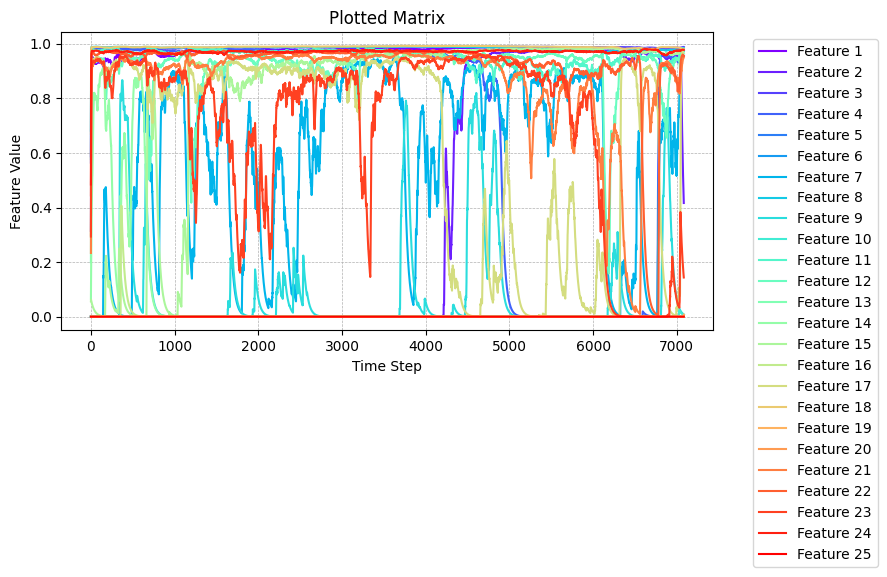

In [81]:
# create hidden state sequences
T = 0.4
AY = 1
S = 1/SAMPLING_RATE

hidden_state_sequence_array = ltc.create_hidden_state_sequences(datas_array, tau=T, A=AY, step_size=S)
val_hidden_state_sequence_array = ltc.create_hidden_state_sequences(val_datas_array, tau=T, A=AY, step_size=S)

# for i, hidden_state_sequence in enumerate(hidden_state_sequence_array):
#     plot_matrix(hidden_state_sequence, title=f"Training Sample {i} Hidden State Evolution")
    
# for i, val_hidden_state_sequence in enumerate(val_hidden_state_sequence_array):
#     plot_matrix(val_hidden_state_sequence, title=f"Validation Sample {i} Hidden State Evolution")

for i in range(1):
    plot_matrix(val_hidden_state_sequence_array[i])


In [82]:
# create the mlp, criterion, and optimizer
mlp = MLP([hidden_state_features, hidden_state_features, hidden_state_features, output_features]).to(device)

In [83]:
# criterion = nn.CrossEntropyLoss() # Interestingly, doesn't work with single-input single-output network
criterion = nn.MSELoss()

# optimizer = optim.SGD(mlp.parameters(), lr=0.05, momentum=0.9)
# optimizer = optim.Adadelta(mlp.parameters(), lr=0.05)
optimizer = optim.Adamax(mlp.parameters(), lr=0.01) # best optimizer thus far
# optimizer = optim.Adam(mlp.parameters(), lr=0.01)

In [84]:
# create outputs before training
outputs_before_array = []
val_outputs_before_array = []

for hidden_state_sequence in hidden_state_sequence_array:
    outputs_before_array.append(mlp.create_outputs_sequence(hidden_state_sequence))
    
for val_hidden_state_sequence in val_hidden_state_sequence_array:
    val_outputs_before_array.append(mlp.create_outputs_sequence(val_hidden_state_sequence))


In [85]:
# train the mlp
mlp.advanced_train_model(hidden_state_sequence_array,
# mlp.advanced_train_model(datas_array,
                        labels_array,
                        optimizer=optimizer,
                        criterion=criterion,
                        epochs=600)


[Epoch 1] loss: 0.20735
[Epoch 2] loss: 0.20078
[Epoch 3] loss: 0.19322
[Epoch 4] loss: 0.17997
[Epoch 5] loss: 0.17565
[Epoch 6] loss: 0.17587
[Epoch 7] loss: 0.17612
[Epoch 8] loss: 0.17474
[Epoch 9] loss: 0.17205
[Epoch 10] loss: 0.16902
[Epoch 11] loss: 0.16648
[Epoch 12] loss: 0.16482
[Epoch 13] loss: 0.16394
[Epoch 14] loss: 0.16322
[Epoch 15] loss: 0.16204
[Epoch 16] loss: 0.16018
[Epoch 17] loss: 0.15792
[Epoch 18] loss: 0.15572
[Epoch 19] loss: 0.15399
[Epoch 20] loss: 0.15282
[Epoch 21] loss: 0.15190
[Epoch 22] loss: 0.15083
[Epoch 23] loss: 0.14945
[Epoch 24] loss: 0.14788
[Epoch 25] loss: 0.14633
[Epoch 26] loss: 0.14502
[Epoch 27] loss: 0.14402
[Epoch 28] loss: 0.14317
[Epoch 29] loss: 0.14221
[Epoch 30] loss: 0.14096
[Epoch 31] loss: 0.13963
[Epoch 32] loss: 0.13856
[Epoch 33] loss: 0.13776
[Epoch 34] loss: 0.13696
[Epoch 35] loss: 0.13593
[Epoch 36] loss: 0.13477
[Epoch 37] loss: 0.13368
[Epoch 38] loss: 0.13280
[Epoch 39] loss: 0.13200
[Epoch 40] loss: 0.13105
[Epoch 41

In [86]:
# create outputs after training
outputs_after_array = []
val_outputs_after_array = []

for hidden_state_sequence in hidden_state_sequence_array:
    outputs_after_array.append(mlp.create_outputs_sequence(hidden_state_sequence))
    
for val_hidden_state_sequence in val_hidden_state_sequence_array:
    val_outputs_after_array.append(mlp.create_outputs_sequence(val_hidden_state_sequence))

if binarise:
    outputs_after_array = binarise_tensors(outputs_after_array)
    val_outputs_after_array = binarise_tensors(val_outputs_after_array)



In [87]:
# performance metrics
accuracy_radius = 0.2
average_training_accuracy = 0
average_validation_accuracy = 0


def accuracy_of_sample(predictions, labels, radius):
    # Ensure both tensors are on the same device
    if predictions.device != labels.device:
        raise ValueError("Predictions and labels must be on the same device")

    differences = torch.abs(predictions - labels) # Calculate the absolute difference between predictions and labels
    within_radius = torch.all(differences <= radius, dim=1) # Check if each sample is within the radius
    accuracy = torch.mean(within_radius.float()) * 100 # Calculate the percentage of samples within the radius

    return accuracy.item()

def calculate_r_squared(prediction_tensors, label_tensors):
    """
    Calculate the R-squared (coefficient of determination) for each of the two output variables.
    
    Args:
    prediction_tensors (list of torch.Tensor): List of prediction tensors, each with shape (n, 2)
    label_tensors (list of torch.Tensor): List of label tensors, each with shape (n, 2)
    
    Returns:
    tuple: (R-squared for first output, R-squared for second output)
    """
    all_predictions = []
    all_labels = []
    
    for prediction_tensor, label_tensor in zip(prediction_tensors, label_tensors):
        # Ensure both tensors are on the same device
        if prediction_tensor.device != label_tensor.device:
            raise ValueError("Prediction tensor and label tensor must be on the same device")
        
        all_predictions.append(prediction_tensor)
        all_labels.append(label_tensor)
    
    # Concatenate all tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate R-squared for each output variable
    r_squared = []
    for i in range(2):  # For each of the two output variables
        y_true = all_labels[:, i]
        y_pred = all_predictions[:, i]
        
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        ss_res = torch.sum((y_true - y_pred) ** 2)
        
        r2 = 1 - (ss_res / ss_tot)
        r_squared.append(r2.item())
    
    return tuple(r_squared)

for i in range(len(val_datas_array)):
    print(f"Accuracy of validation sample {i}: {accuracy_of_sample(val_outputs_after_array[i], val_labels_array[i], accuracy_radius)}")
    average_validation_accuracy += accuracy_of_sample(val_outputs_after_array[i], val_labels_array[i], accuracy_radius)

training_r2_before = calculate_r_squared(outputs_before_array, labels_array)
training_r2_after = calculate_r_squared(outputs_after_array, labels_array)

print(f"Training Sets R-squared of valence before training: {training_r2_before[0]}")
print(f"Training Sets R-squared of arousal before training: {training_r2_before[1]}")
print(f"Training Sets R-squared of valence after training: {training_r2_after[0]}")
print(f"Training Sets R-squared of arousal after training: {training_r2_after[1]}")

# print(f"Average Training Accuracy: {average_training_accuracy / len(datas_array)}")
print(f"Average Validation Accuracy: {average_validation_accuracy / len(val_datas_array)}")


Accuracy of validation sample 0: 6.126482009887695
Accuracy of validation sample 1: 11.905893325805664
Training Sets R-squared of valence before training: -0.15186727046966553
Training Sets R-squared of arousal before training: 0.051971495151519775
Training Sets R-squared of valence after training: 0.7190790772438049
Training Sets R-squared of arousal after training: 0.8012269139289856
Average Validation Accuracy: 9.01618766784668


In [88]:
r2_before = calculate_r_squared(val_outputs_before_array, val_labels_array)
r2_after = calculate_r_squared(val_outputs_after_array, val_labels_array)
print(f"Validation Sets R-squared of valence before training: {r2_before[0]}")
print(f"Validation Sets R-squared of arousal before training: {r2_before[1]}")
print(f"Validation Sets R-squared of valence after training: {r2_after[0]}")
print(f"Validation Sets R-squared of arousal after training: {r2_after[1]}")



Validation Sets R-squared of valence before training: -1.9116685390472412
Validation Sets R-squared of arousal before training: -1.4981966018676758
Validation Sets R-squared of valence after training: -2.5424537658691406
Validation Sets R-squared of arousal after training: -1.8048510551452637


In [89]:
sample = 0
plot_in_time([val_labels_array[sample], val_outputs_after_array[sample]],
            labels=[f"Validation Sample {sample} Labels", f"Validation Sample {sample} After"])

In [90]:
# Saving the model parameters
def save_model_parameters(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")

# Loading the model parameters
def load_model_parameters(model, file_path):
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from: {file_path}")
    return model

In [91]:
# save_model_parameters(mlp, r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\MLP-3HS-OUT.pth")
# save_model_parameters(ltc, r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\LTC-T099-A1.pth")
# save_pca_info(pca_info, r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\PCA_info.pkl")

In [92]:
# loaded_mlp = load_model_parameters(mlp, r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\DSI_PytorchLTC_model.pth")
# loaded_ltc = load_model_parameters(ltc, r"C:\Users\Daniel Chahine\Desktop\EEGStuff-main\DSI_PytorchLTC_ltc_model.pth")

# plot_in_time([loaded_mlp.create_outputs_sequence(loaded_ltc.create_hidden_state_sequences([datas_array[0]], tau=T, A=AY, step_size=S)[0]), labels_array[0]],
            # labels=[f"Loaded MLP Output", f"Labels"])

# def print_device(name, obj):
#     if isinstance(obj, torch.Tensor):
#         print(f"{name} is on: {obj.device}")
#     elif isinstance(obj, nn.Module):
#         print(f"{name} is on: {next(obj.parameters()).device}")
#     elif isinstance(obj, list) and all(isinstance(item, torch.Tensor) for item in obj):
#         print(f"{name} contains tensors on: {obj[0].device}")
#     else:
#         print(f"Unable to determine device for {name}")

# print_device("ltc", ltc)
# print_device("mlp", mlp)
# print_device("datas_array", datas_array)
# print_device("hidden_state_sequence_array", hidden_state_sequence_array)
# print_device("val_hidden_state_sequence_array", val_hidden_state_sequence_array)
# print_device("labels_array", labels_array)
# print_device("val_labels_array", val_labels_array)
